# Standard $\Lambda$CDM Model of Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from Planck18 import *
from constants import *

%matplotlib inline

In [2]:
#? Necessary Functions from "Distances.ipynb"
a_z = lambda z: 1 / (1+z)  

def d_eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0):
    return c / 1000 / (H0*np.sqrt((Omega_m*a)+Omega_rad+(Omega_k*a**2)+Omega_Lambda*a**4))

def eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0): 
    return integrate.romberg(d_eta, a, 1, args=(Omega_m, Omega_rad, Omega_k, Omega_Lambda, H0), rtol=1e-2)

def comoving_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0):
    et = eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0)
    if Omega_k < 0:
        return  c* np.sin(H0 * np.sqrt(-Omega_k) * et / c) / H0 / np.sqrt(-Omega_k)
    elif Omega_k > 0:
        return c * np.sinh(H0 * np.sqrt(Omega_k) * et / c, dtype=np.float128) / H0 / np.sqrt(Omega_k)
    else:
        return et

def angular_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0):
    return a * comoving_distance(a, Omega_m, Omega_rad, Omega_k, Omega_Lambda, H0)

def luminosity_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0):
    return angular_distance(a, Omega_m, Omega_rad, Omega_k, Omega_Lambda, H0) / a**2

### Distance Modulus ($\mu$)

$\mu = m - M = 5\log_{10} [d_L]+ 25$

In [3]:
def distance_modulus(z, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, Omega_Lambda=Omega_Lambda, H0=H0):
    a = a_z(z)
    dL = luminosity_distance(a, Omega_m, Omega_rad, Omega_k, Omega_Lambda, H0)
    return 5 * np.log10(dL) + 25

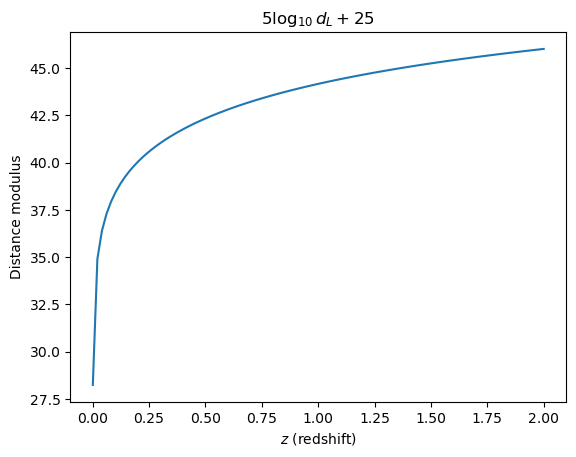

In [4]:
Z = np.linspace(1e-3, 2, 100)
MU = np.array(list(map(distance_modulus, Z)))
plt.plot(Z, MU)
plt.xlabel("$z$ (redshift)")
plt.ylabel("Distance modulus")
plt.title(r'$5\log_{10}d_L+25$')
plt.show()

Comparing this to the Union 2.1 Supernovae data

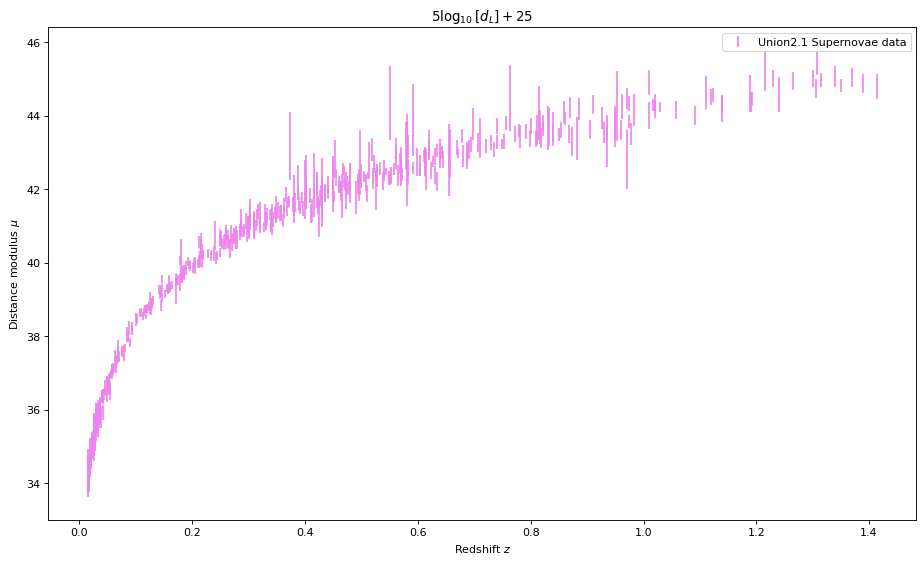

In [5]:
Z_SN, MU_SN, Delta_MU_SN = np.loadtxt('Data/sn_z_mu_dmu_plow_union2.1.txt', usecols=(1, 2, 3),  unpack=True)
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(Z_SN, MU_SN, yerr=Delta_MU_SN, linestyle="", label='Union2.1 Supernovae data', c='violet')
plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance modulus $\mu$")
plt.title(r"$5\log_{10} [d_L] + 25$")
plt.legend()
plt.show()

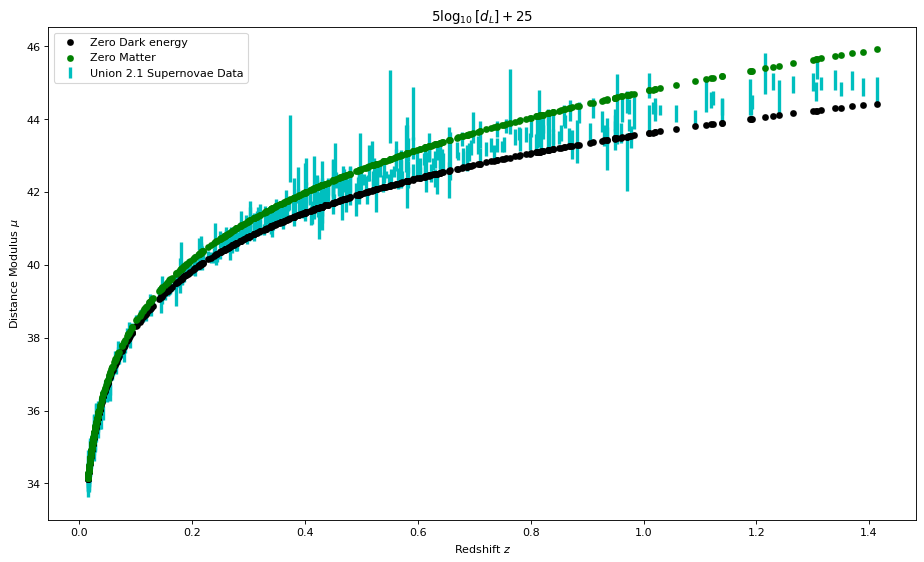

In [6]:
MU_Lambda = []                                    #? Zero Dark energy
MU_m = []                                         #? Zero Matter
for i in range(len(Z_SN)):
    MU_Lambda.append(distance_modulus(Z_SN[i], Omega_m=1-Omega_rad, Omega_rad=Omega_rad, Omega_k=0, Omega_Lambda=0))
    MU_m.append(distance_modulus(Z_SN[i], Omega_m=0, Omega_rad=Omega_rad, Omega_k=0, Omega_Lambda=1-Omega_rad))

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(Z_SN, MU_SN, yerr=Delta_MU_SN, linestyle="", c='c', label="Union 2.1 Supernovae Data", zorder=0, linewidth=3)
plt.scatter(Z_SN, MU_Lambda, c='k', zorder=5, linestyle="-", label='Zero Dark energy', linewidths=0.1)
plt.scatter(Z_SN, MU_m, c='g', zorder=5, linestyle="-", label='Zero Matter', linewidths=0.1)
plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance Modulus $\mu$")
plt.title(r"$5\log_{10} [d_L] + 25$")
plt.legend()
plt.show()

### Goodness of fit ($\chi^2$)

$\chi^2 = \sum_{i=1}^N \left( \frac{D(i) - T(i)}{\sigma(i)} \right)^2$ <br>
We have $N$ data points $D(i)$ and errors $\sigma(i)$ which we compare to our theory $T(i)$

In [7]:
chi_square = lambda D, T, E: np.sum(((D - T) / E)**2) 
print("Zero Matter: ", chi_square(MU_m, MU_SN, Delta_MU_SN))
print("Zero Dark Energy: ", chi_square(MU_Lambda, MU_SN, Delta_MU_SN))
print("Observed values: ", chi_square(list(map(distance_modulus, Z_SN)), MU_SN, Delta_MU_SN))

Zero Matter:  1876.991367446451
Zero Dark Energy:  1548.5310317621766
Observed values:  657.3630620109816


We try to obtain the values of our parameters by minimizing $\chi^2$ <br>
Here, we try to constain $H_0$ and $\Omega_m$

In [8]:
def chi_square_SN(H0, Omega_m):
    '''
    Returns the chi^2 value of the distance modulus for any given values of H0 and Omega_m
    '''
    if (Omega_m < 0 or Omega_m > 1 or H0 < 30 or H0 > 100):                   
        return np.inf                                                #? Out of bounds
    
    MU = []
    Omega_l = 1 - Omega_m - Omega_rad - Omega_k
    for i in range(len(Z_SN)):
        MU.append(distance_modulus(Z_SN[i], Omega_m=Omega_m, Omega_Lambda=Omega_l, H0=H0))
        
    return chi_square(MU, MU_SN, Delta_MU_SN)

def bestfit(bounds, tries):
    best_chi_square = 1e30                                     #? A very large value
    CHI = np.zeros((tries, tries))
    OMEGA_M = np.linspace(bounds[0][0], bounds[0][1], tries)
    H = np.linspace(bounds[1][0], bounds[1][1], tries)
    
    for i in range(tries):
        for j in range(tries):
            chi_sq_SN = chi_square_SN(H[i], OMEGA_M[j])
            CHI[i][j] = chi_sq_SN
            if chi_sq_SN < best_chi_square:
                best_chi_square = chi_sq_SN
                best_fit = (H[i], OMEGA_M[j])
    
    return best_fit, best_chi_square, CHI

H0 =  70.52631578947368
Omega_m =  0.24210526315789474
Best chi-square value =  565.8038087209907


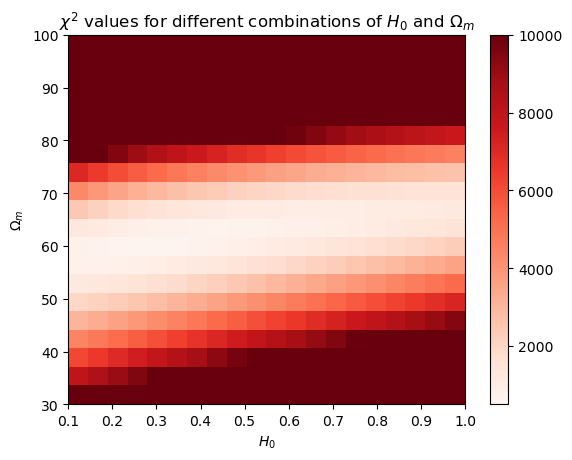

In [9]:
bounds = [[0.1, 1], [30, 100]]
tries = 20

best_fit, best_chi_square, CHI = bestfit(bounds, tries)
print("H0 = ", best_fit[0])
print("Omega_m = ", best_fit[1])
print("Best chi-square value = ", best_chi_square)

plt.imshow(CHI, cmap=plt.cm.Reds, vmin=500, vmax=1e4, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], aspect='auto')
plt.colorbar()
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_m$")
plt.title(r"$\chi^2$ values for different combinations of $H_0$ and $\Omega_m$")
plt.show()